In [1]:
import torch    
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
from torch.cuda.amp import autocast, GradScaler

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from tqdm import tqdm 

c:\Users\Administrator\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Dataset2class(torch.utils.data.Dataset):
    def __init__(self, path_dir1:str, path_dir2:str):
        super().__init__()

        self.path_dir1 = path_dir1
        self.path_dir2 = path_dir2

        self.dir1_list = sorted(os.listdir(path_dir1))
        self.dir2_list = sorted(os.listdir(path_dir2))

    def __len__(self):
        return len(self.dir1_list) + len(self.dir2_list)

    def __getitem__(self, idx):
        if idx < len(self.dir1_list):
            class_id = 0
            img_path = os.path.join(self.path_dir1, self.dir1_list[idx])
        else:
            class_id = 1
            idx -= len(self.dir1_list)
            img_path = os.path.join(self.path_dir2, self.dir2_list[idx])

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            raise ValueError(f"Изображение по пути {img_path} не может быть загружено.")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        img = img/255.0

        img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)

        img = img.transpose((2, 0, 1))

        t_img = torch.from_numpy(img)
        t_class_id = torch.tensor(class_id)

        return {'img' : t_img, 'label' :  t_class_id}

In [3]:
train_ds_catsdogs = Dataset2class('C:/Users/Administrator/Desktop/AAT/ResNet/dataset/training_set/cats',
                             'C:/Users/Administrator/Desktop/AAT/ResNet/dataset/training_set/dogs')
test_ds_catsdogs = Dataset2class('C:/Users/Administrator/Desktop/AAT/ResNet/dataset/test_set/cats',
                             'C:/Users/Administrator/Desktop/AAT/ResNet/dataset/test_set/dogs')


In [4]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(
    train_ds_catsdogs, shuffle=True, batch_size=batch_size,
    num_workers=0, drop_last=True)
test_loader = torch.utils.data.DataLoader(
    test_ds_catsdogs, shuffle=True, batch_size=batch_size,
    num_workers=0, drop_last=False)

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.act = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.conv0 = nn.Conv2d(3, 128, 3, stride=1, padding=0)
        self.conv1 = nn.Conv2d(128, 128, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(128, 128, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=0)

        self.adaptivepool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(256, 20)
        self.linear2 = nn.Linear(20, 2)

    
    def forward(self, x):
        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv1(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.act(out)
        out = self.maxpool(out)
  
        out = self.conv3(out)
        out = self.act(out)

        out = self.adaptivepool(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)

        return out

In [6]:
model = ConvNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma = 0.6
)

In [7]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
    # print(answer)
    # print(answer.sum())
    return answer.mean()


In [10]:
device = 'cuda'
model = model.to(device)
loss_fn = loss_fn.to(device)

In [11]:
use_amp = True
scaler = torch.cuda.amp.GradScaler()
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

In [12]:
epochs = 5
loss_epochs_list = []
acc_epochs_list = []
for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(train_loader)):
        img, label = sample['img'], sample['label']
        label = F.one_hot(label, 2).float()
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()

        with autocast(use_amp):
            pred = model(img)
            loss = loss_fn(pred, label)
        
        scaler.scale(loss).backward()
        loss_item = loss.item()
        loss_val += loss_item

        scaler.step(optimizer)
        scaler.update()

        acc_current = accuracy(pred.cpu().float(), label.cpu().float())
        acc_val += acc_current

        pbar.set_description(f'loss: {loss_item:.4f}\taccuracy: {acc_current:.3f}')
    scheduler.step()
    loss_epochs_list += [loss_val/len(train_loader)]
    acc_epochs_list += [acc_val/len(train_loader)]
    print(loss_epochs_list[-1])
    print(acc_epochs_list[-1])

  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\Administrator\AppData\Local\Temp\ipykernel_8016\3440098169.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
loss: 0.6219	accuracy: 0.562: 100%|██████████| 500/500 [00:48<00:00, 10.38it/s]


0.6950701217651367
0.517375


loss: 0.6480	accuracy: 0.500: 100%|██████████| 500/500 [00:49<00:00, 10.16it/s]


0.6764818420410156
0.577


loss: 0.6112	accuracy: 0.625: 100%|██████████| 500/500 [00:48<00:00, 10.31it/s]


0.6432076041698456
0.632875


loss: 0.9517	accuracy: 0.375: 100%|██████████| 500/500 [00:48<00:00, 10.39it/s]


0.6069187990427017
0.665125


loss: 0.5277	accuracy: 0.750: 100%|██████████| 500/500 [00:47<00:00, 10.52it/s]

0.5734071055650711
0.704


In [13]:
loss_epochs_list_naive = loss_epochs_list.copy()
acc_epochs_list_naive = acc_epochs_list.copy()

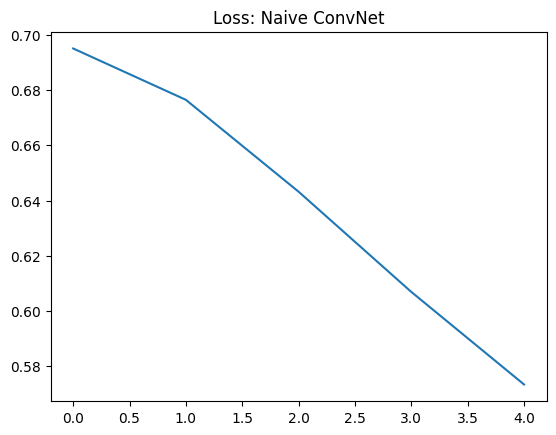

In [14]:
plt.title('Loss: Naive ConvNet')
plt.plot(loss_epochs_list_naive)

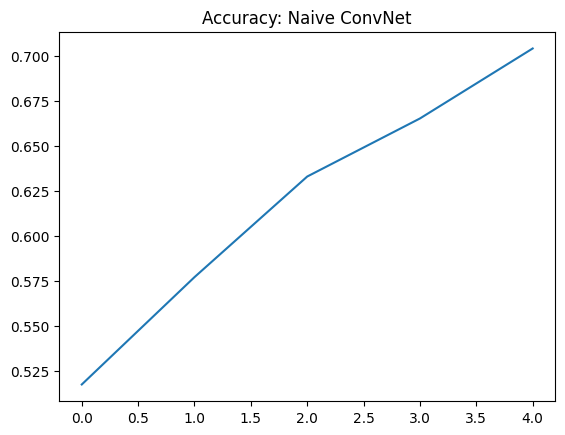

In [15]:
plt.title('Accuracy: Naive ConvNet')
plt.plot(acc_epochs_list_naive)

In [24]:
model_res = tv.models.resnet.resnet34()

In [25]:
model_res

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
class ResBlock(nn.Module):
    def __init__(self, nc):
        super().__init__()
        self.conv0 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm0 = nn.BatchNorm2d(nc)
        self.act = nn.LeakyReLU(0.2, inplace=True)
        self.conv1 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(nc)

    def forward(self, x):
        out = self.conv0(x)
        out = self.norm1(out) 
        out = self.act(out)
        out = self.conv0(x)
        out = self.norm1(out) 

        return self.act(x + out)

In [28]:
class ResTruck(nn.Module):
    def __init__(self, nc, num_blocks):
        super().__init__()
        truck = []
        for i in range(num_blocks):
            truck +=[ResBlock(nc)]
        self.truck = nn.Sequential(*truck)

    def forward(self, x):

        return self.truck(x)

In [48]:
class ResNet(nn.Module):
    def __init__(self, in_nc, nc, out_nc):
        super().__init__()
        self.conv0 = nn.Conv2d(in_nc, nc, kernel_size=7, stride=2)
        self.act = nn.LeakyReLU(0.2, inplace=True)
        self.maxpool = nn.MaxPool2d(2, 2)

        self.layer1  = ResTruck(nc, 3)
        self.conv1 = nn.Conv2d(nc, 2*nc, 3, padding=1, stride=2)
        self.layer2  = ResTruck(2*nc, 4)
        self.conv2 = nn.Conv2d(2*nc, 4*nc, 3, padding=1, stride=2)
        self.layer3  = ResTruck(4*nc, 6)
        self.conv3= nn.Conv2d(4*nc, 4*nc, 3, padding=1, stride=2)
        self.layer4  = ResTruck(4*nc, 3)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4*nc, out_nc)
    def forward(self, x):
        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.conv1(out)
        out = self.layer2(out)
        out = self.conv2(out)
        out = self.layer3(out)
        out = self.conv3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = self.flatten(out)
        out = self.linear(out)

        return out

In [49]:
def count_parametrs(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [50]:
resnet_module = ResNet(3, 32, 2)

In [51]:
count_parametrs(resnet_module)

3258370

In [52]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_module.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma = 0.6
)

In [53]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
    # print(answer)
    # print(answer.sum())
    return answer.mean()


In [54]:
device = 'cuda'
resnet_module = resnet_module.to(device)
loss_fn = loss_fn.to(device)

In [55]:
use_amp = True
scaler = torch.cuda.amp.GradScaler()
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

In [56]:
epochs = 10
loss_epochs_list = []
acc_epochs_list = []
for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(train_loader)):
        img, label = sample['img'], sample['label']
        label = F.one_hot(label, 2).float()
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()

        with autocast(use_amp):
            pred = resnet_module(img)
            loss = loss_fn(pred, label)
        
        scaler.scale(loss).backward()
        loss_item = loss.item()
        loss_val += loss_item

        scaler.step(optimizer)
        scaler.update()

        acc_current = accuracy(pred.cpu().float(), label.cpu().float())
        acc_val += acc_current

        pbar.set_description(f'loss: {loss_item:.4f}\taccuracy: {acc_current:.3f}')
    scheduler.step()
    loss_epochs_list += [loss_val/len(train_loader)]
    acc_epochs_list += [acc_val/len(train_loader)]
    print(loss_epochs_list[-1])
    print(acc_epochs_list[-1])

  0%|          | 0/500 [00:00<?, ?it/s]C:\Users\Administrator\AppData\Local\Temp\ipykernel_25124\3440098169.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
loss: 0.6274	accuracy: 0.438: 100%|██████████| 500/500 [00:50<00:00,  9.98it/s]


0.6841258742809295
0.59075


loss: 0.5505	accuracy: 0.625: 100%|██████████| 500/500 [00:51<00:00,  9.76it/s]


0.6474494781494141
0.624875


loss: 0.6283	accuracy: 0.500: 100%|██████████| 500/500 [00:50<00:00,  9.81it/s]


0.6229063205718994
0.649125


loss: 0.5703	accuracy: 0.812: 100%|██████████| 500/500 [00:49<00:00, 10.15it/s]


0.5837827615737915
0.68925


loss: 0.3096	accuracy: 1.000: 100%|██████████| 500/500 [00:52<00:00,  9.49it/s]


0.531412404537201
0.73775


loss: 0.4841	accuracy: 0.688: 100%|██████████| 500/500 [00:49<00:00, 10.09it/s]


0.47358096718788145
0.77475


loss: 0.4045	accuracy: 0.812: 100%|██████████| 500/500 [00:50<00:00,  9.98it/s]


0.4213584968447685
0.80075


loss: 0.3509	accuracy: 0.812: 100%|██████████| 500/500 [00:51<00:00,  9.79it/s]


0.38946412813663484
0.821375


loss: 0.3247	accuracy: 0.938: 100%|██████████| 500/500 [00:51<00:00,  9.76it/s]


0.3613243546485901
0.83875


loss: 0.3535	accuracy: 0.812: 100%|██████████| 500/500 [00:50<00:00,  9.83it/s]

0.3491710640788078
0.843375


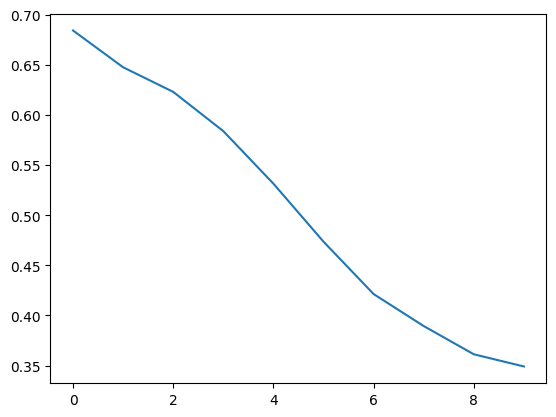

In [58]:
plt.plot(loss_epochs_list)

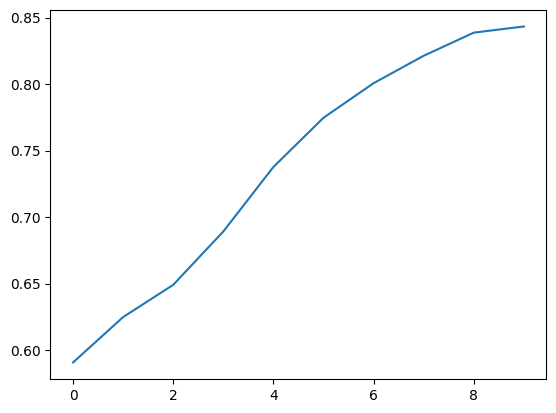

In [59]:
plt.plot(acc_epochs_list)